<a href="https://colab.research.google.com/github/dharul619/analitik-visualisasi-pertemuan-9/blob/master/411222001_Dharul_Yuswansyah_pertemuan_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Database lama dihapus, membuat database baru...
Tabel berhasil dibuat ✅
Data buku & anggota berhasil ditambahkan ✅
Data peminjaman berhasil ditambahkan ✅

Daftar Peminjaman:


,id,nama,judul,tgl_pinjam,tgl_kembali
0,1,Dharul Yuswansyah,Laskar Pelangi,2025-11-01,2025-11-05
1,2,Andi Setiawan,Bumi Manusia,2025-11-02,2025-11-08
2,3,Sinta Rahma,Filosofi Kopi,2025-11-04,None
3,4,Dharul Yuswansyah,Negeri 5 Menara,2025-11-06,2025-11-10




Jumlah buku yang dipinjam per anggota:


,nama,total_buku_dipinjam
0,Andi Setiawan,1
1,Dharul Yuswansyah,2
2,Sinta Rahma,1




Data dengan durasi peminjaman:


,id,nama,judul,tgl_pinjam,tgl_kembali,durasi_hari
0,1,Dharul Yuswansyah,Laskar Pelangi,2025-11-01,2025-11-05,4.0
1,2,Andi Setiawan,Bumi Manusia,2025-11-02,2025-11-08,6.0
2,3,Sinta Rahma,Filosofi Kopi,2025-11-04,None,NaN
3,4,Dharul Yuswansyah,Negeri 5 Menara,2025-11-06,2025-11-10,4.0




Buku yang belum dikembalikan:


,id,nama,judul,tgl_pinjam,tgl_kembali,durasi_hari
2,3,Sinta Rahma,Filosofi Kopi,2025-11-04,None,NaN




⏱️ Rata-rata lama peminjaman: 4.7 hari


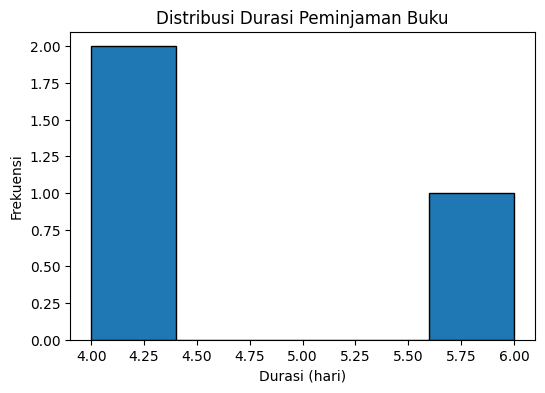

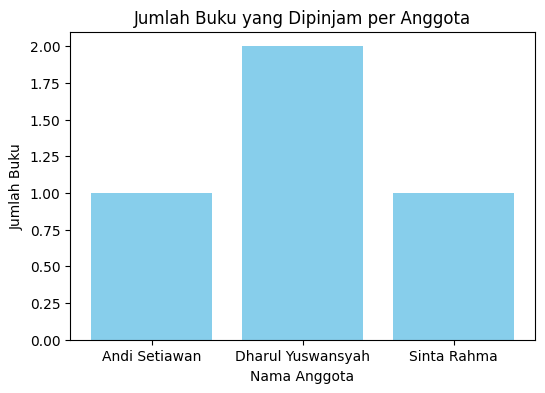

Koneksi database ditutup ✅


In [15]:
# ===============================
# 1. Import library
# ===============================
import sqlite3
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os

# ===============================
# 2. Pastikan koneksi lama ditutup dan database bersih
# ===============================
try:
    conn.close()
except:
    pass

if os.path.exists("perpustakaan.db"):
    os.remove("perpustakaan.db")
    print("Database lama dihapus, membuat database baru...")
else:
    print("Database baru akan dibuat...")

# ===============================
# 3. Membuat koneksi ke database SQLite (file lokal)
# ===============================
conn = sqlite3.connect('perpustakaan.db', check_same_thread=False)
cursor = conn.cursor()

# ===============================
# 4. Membuat tabel-tabel
# ===============================
cursor.execute('''
CREATE TABLE IF NOT EXISTS buku (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    judul TEXT NOT NULL,
    penulis TEXT NOT NULL,
    tahun INTEGER
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS anggota (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    nama TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS peminjaman (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    id_anggota INTEGER,
    id_buku INTEGER,
    tgl_pinjam TEXT,
    tgl_kembali TEXT,
    FOREIGN KEY (id_anggota) REFERENCES anggota(id),
    FOREIGN KEY (id_buku) REFERENCES buku(id)
)
''')

conn.commit()
print("Tabel berhasil dibuat ✅")

# ===============================
# 5. Menambahkan data buku
# ===============================
buku_data = [
    ("Laskar Pelangi", "Andrea Hirata", 2005),
    ("Bumi Manusia", "Pramoedya Ananta Toer", 1980),
    ("Filosofi Kopi", "Dee Lestari", 2006),
    ("Negeri 5 Menara", "Ahmad Fuadi", 2009),
    ("Pulang", "Leila S. Chudori", 2012)
]

cursor.executemany("INSERT INTO buku (judul, penulis, tahun) VALUES (?, ?, ?)", buku_data)

# ===============================
# 6. Menambahkan data anggota
# ===============================
anggota_data = [
    ("Dharul Yuswansyah", "dharul@example.com"),
    ("Andi Setiawan", "andi@example.com"),
    ("Sinta Rahma", "sinta@example.com")
]

cursor.executemany("INSERT INTO anggota (nama, email) VALUES (?, ?)", anggota_data)

conn.commit()
print("Data buku & anggota berhasil ditambahkan ✅")

# ===============================
# 7. Menambahkan data peminjaman
# ===============================
peminjaman_data = [
    (1, 1, "2025-11-01", "2025-11-05"),
    (2, 2, "2025-11-02", "2025-11-08"),
    (3, 3, "2025-11-04", None),  # belum dikembalikan
    (1, 4, "2025-11-06", "2025-11-10")
]

cursor.executemany("""
INSERT INTO peminjaman (id_anggota, id_buku, tgl_pinjam, tgl_kembali)
VALUES (?, ?, ?, ?)
""", peminjaman_data)

conn.commit()
print("Data peminjaman berhasil ditambahkan ✅")

# ===============================
# 8. Query dengan JOIN
# ===============================
query_join = '''
SELECT p.id, a.nama, b.judul, p.tgl_pinjam, p.tgl_kembali
FROM peminjaman p
JOIN anggota a ON p.id_anggota = a.id
JOIN buku b ON p.id_buku = b.id
'''

df_peminjaman = pd.read_sql_query(query_join, conn)
print()
print("Daftar Peminjaman:")
display(df_peminjaman)
print()
print()

# ===============================
# 9. Query GROUP BY dan COUNT
# ===============================
query_group = '''
SELECT a.nama, COUNT(p.id_buku) AS total_buku_dipinjam
FROM peminjaman p
JOIN anggota a ON p.id_anggota = a.id
GROUP BY a.nama
'''

df_jumlah = pd.read_sql_query(query_group, conn)
print("Jumlah buku yang dipinjam per anggota:")
display(df_jumlah)
print()
print()

# ===============================
# 10. Membuat DataFrame dari hasil JOIN
# ===============================
df = df_peminjaman.copy()

# ===============================
# 11. Menghitung durasi peminjaman (dalam hari)
# ===============================
def hitung_durasi(row):
    if pd.isnull(row['tgl_kembali']):
        return None
    else:
        start = datetime.strptime(row['tgl_pinjam'], "%Y-%m-%d")
        end = datetime.strptime(row['tgl_kembali'], "%Y-%m-%d")
        return (end - start).days

df['durasi_hari'] = df.apply(hitung_durasi, axis=1)

print("Data dengan durasi peminjaman:")
display(df)
print()
print()

# ===============================
# 12. Eksplorasi sederhana
# ===============================
belum_kembali = df[df['tgl_kembali'].isnull()]
print("Buku yang belum dikembalikan:")
display(belum_kembali)
print()
print()

rata_rata = df['durasi_hari'].mean()
print(f"Rata-rata lama peminjaman: {rata_rata:.1f} hari")

# ===============================
# 13. Visualisasi durasi peminjaman
# ===============================
plt.figure(figsize=(6,4))
df
df['durasi_hari'].dropna().plot(kind='hist', bins=5, edgecolor='black')
plt.title("Distribusi Durasi Peminjaman Buku")
plt.xlabel("Durasi (hari)")
plt.ylabel("Frekuensi")
plt.show()

# ===============================
# 14. Visualisasi jumlah buku yang dipinjam per anggota
# ===============================
plt.figure(figsize=(6,4))
plt.bar(df_jumlah['nama'], df_jumlah['total_buku_dipinjam'], color='skyblue')
plt.title("Jumlah Buku yang Dipinjam per Anggota")
plt.xlabel("Nama Anggota")
plt.ylabel("Jumlah Buku")
plt.show()

# ===============================
# 15. Tutup koneksi database
# ===============================
conn.close()
print("Koneksi database ditutup ✅")